<a href="https://colab.research.google.com/github/SeohyunLyoo/Study/blob/main/Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="Chat BotData.csv")
data = pd.read_csv('Chat BotData.csv')
data = data[0:5290]


In [2]:
#train_data = data.sample(frac=1).reset_index(drop=True)
train_data = data

In [3]:
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
questions = []
for sentence in train_data['Q']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

answers = []
for sentence in train_data['A']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [5]:
#서브워드텍스트인코더 사용
tokenizer = tfds.deprecated.text. SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

START_TOKEN, END_TOKEN = [tokenizer. vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2

In [6]:
print('임의의 질문 샘플 정수 인코딩 : {}'.format(tokenizer.encode(questions [20])))

MAX_LENGTH = 40

# 점수 인코딩 & 패딩
def tokenize_and_filter(inputs, outputs):
   tokenized_inputs, tokenized_outputs = [], []

   for (sentence1, sentence2) in zip(inputs, outputs):
      # encode(토큰화 + 점수 인코딩), 시작 토큰과 종료 토큰 추가
      sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
      sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

   #패딩
   tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences( tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
   tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences( tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

   return tokenized_inputs, tokenized_outputs


임의의 질문 샘플 정수 인코딩 : [3177, 5600, 220, 863, 6238]


In [7]:
questions, answers = tokenize_and_filter(questions, answers)
print(questions.shape), print(answers.shape)

(5290, 40)
(5290, 40)


(None, None)

In [8]:
questions[0]

array([7612, 7353, 7388, 7591, 7505, 7517,   11, 7613,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [9]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs' : questions,
        'dec_inputs' : answers [:, :-1] # 0389 92. D 8 52 H
    },
    {
        'outputs' : answers [:, 1:]
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


In [10]:
# dataset 확인
for inputs, outputs in dataset.take(1):
    print("Inputs:", inputs)
    print("Dec Inputs:", inputs['dec_inputs'])
    print("Outputs:", outputs['outputs'])

Inputs: {'inputs': <tf.Tensor: shape=(64, 40), dtype=int32, numpy=
array([[7612,  876, 1303, ...,    0,    0,    0],
       [7612,  205, 5908, ...,    0,    0,    0],
       [7612,   53,  201, ...,    0,    0,    0],
       ...,
       [7612,  949, 6811, ...,    0,    0,    0],
       [7612,   62,   69, ...,    0,    0,    0],
       [7612, 1994,  391, ...,    0,    0,    0]], dtype=int32)>, 'dec_inputs': <tf.Tensor: shape=(64, 39), dtype=int32, numpy=
array([[7612,   37,  876, ...,    0,    0,    0],
       [7612, 2258, 2345, ...,    0,    0,    0],
       [7612,   15, 5108, ...,    0,    0,    0],
       ...,
       [7612, 1152,  991, ...,    0,    0,    0],
       [7612, 1060,  139, ...,    0,    0,    0],
       [7612, 5072, 5179, ...,    0,    0,    0]], dtype=int32)>}
Dec Inputs: tf.Tensor(
[[7612   37  876 ...    0    0    0]
 [7612 2258 2345 ...    0    0    0]
 [7612   15 5108 ...    0    0    0]
 ...
 [7612 1152  991 ...    0    0    0]
 [7612 1060  139 ...    0    0    0]
 [

In [11]:
def transformer (vocab_size, num_layers, dff,
                 d_model, num_heads, dropout,
                 name="transformer"):

    # 인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더의 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더의 룩 어헤드 마스크 (첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 디코더의 패딩 마스크 (두번째 서브층)
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
                          d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[inputs, enc_padding_mask]) # 349 932 92 27 H & D^3

    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
                          d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 다음 단어 예측을 위한 출력층
    outputs = tf.keras. layers. Dense (units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras. Model (inputs=[inputs, dec_inputs], outputs=outputs, name=name)


In [12]:
class PositionalEncoding(tf.keras. layers. Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position + angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스 (21)에는 사인 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])

        # 배열의 출수 인덱스 (2i+1)에는 코사인 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding [tf.newaxis, ...]

        print (pos_encoding.shape)
        return tf.cast (pos_encoding, tf.float32)

    def call(self, inputs):
        if isinstance(inputs, tf.sparse.SparseTensor):
            inputs = tf.sparse.to_dense(inputs)
        return inputs + self.pos_encoding[:, tf.shape(inputs) [1], :]


In [13]:
def create_padding_mask(x):
    mask= tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size. 1. 1. kaya 22011
    return mask [:, tf.newaxis, tf.newaxis, :]

# 디코더의 첫 번째 서브층 (EUub layer)에서 미래 토큰을 Mask 하는 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x) # & 0^35 #8
    return tf.maximum(look_ahead_mask, padding_mask)

#encoder
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
    inputs = tf.keras. Input (shape=(None,), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras. Input (shape=(1, 1, None), name="padding_mask")

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast (d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras. layers. Dropout (rate=dropout)(embeddings)

    # 인코더를 num_layer6개 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                                dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

    return tf.keras.Model(
    inputs = [inputs, padding_mask], outputs= outputs, name=name)


In [14]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):

    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query' : inputs, 'key' : inputs, 'value': inputs, # Q = K = V
            'mask' : padding_mask #& DIENS
    })

    # 드롭아웃 + 잔차 연결과 츰 정규화
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention= tf.keras. layers. LayerNormalization(
        epsilon=1e-6) (inputs + attention)

    # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 츰 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras. Model(
        inputs = [inputs, padding_mask], outputs=outputs, name=name)


In [15]:
class MultiHeadAttention(tf.keras. layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        # dmodel 을 mum heade로 나눈 값
        # 논문 기준: 84
        self.depth=d_model // self.num_heads

        # WQ, WK, WV에 해당하는 밀집층 정의
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense   = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        # WO에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units=d_model)

    # mum heade 개수만큼 q. k, v를 Bplit 하는 함수
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']

        batch_size = tf.shape(query)[0]

        # 1. WQ, QK, WV에 해당하는 밀집층 지나기
        # Q: (batoh_size, query 93 2101. O model)
        # K: (batch_size, keyo 93 2101. omodell
        # V: (batch_size, valve sg 2101. L model)
        # 참고) 인코더(K-V)-디코더(Q) 어텐션에서는 query 길이와 key, value 의 길이는 다를 수 있다.
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        #2. 헤드 나누기
        # q : (batch_size, num heade, query 93 2101. d__model/num_heade)
        # k : (batoh_size, num_heade, kayo 93 201. ɖ_model/num_heade)
        # v : (batch_size, num_heade, valued 33 2101. & model/num_heade)
        query = self.split_heads(query, batch_size)
        key   = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
        # (batch_size, num_heade, query 93 2101. ɖmodel/num_heade)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, quary 93 201, num_heade, d_model/num_heade)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        #4. all = 242 (concatenate)ôfJl
        # (batch_size, query 9 2101. ɖmodel)
        concat_attention= tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 5. WO에 해당하는 밀집층 지나기
        # (batch_size, query 93 201. Omodel)
        outputs = self.dense(concat_attention)
        return outputs


In [16]:
def scaled_dot_product_attention(query, key, value, mask):

    # query 크기 : (batch_size, num_heade, query 3 2101. d_model/num_heade)
    # kay 크기   : (batch_size, num_heade, key 93 2101. d_model/num_heade)
    # value 크기 : (batch_size, num_ heade, value! 23 2101. omodel/num_heade)
    # padding_mask : (batch_size, 1. 1. key의 문장 길이)
    #Q와 K의 곱 어텐션 스코어 행렬.
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 스케일링
    # dk의 루트값으로 나눠준다.
    depth = tf.cast (tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 00이 된다.
    if mask is not None:
        logits += (mask * -1e9)

    # 소프트맥스 함수는 마지막 차원인 key 의 문장 길이 방향으로 수행된다.
    # attention weight (batch_size, num_heade, query
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # output: (batch_size, num_heade, query 23 201. ɖ_model/num_heade)
    output = tf.matmul (attention_weights, value)
    return output, attention_weights


In [17]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):

    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

    # 디코더는 룩어헤드 마스크 (첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask    = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 포지셔널 인코딩 + 드롭아웃
    embeddings  = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast (d_model, tf.float32))
    embeddings  = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs     = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더를 num layere개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                                dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs = [inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs = outputs,name=name
    )


In [18]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):

    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

    # 룩어헤드 마스크 (첫번째 서브층)
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    # 패딩 마스크(두번째 서브총)
    padding_mask= tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 멀티 헤드 어텐션 (첫번째 서브총 / 마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(
                                    d_model, num_heads, name="attention_1")(inputs={
                                        'query' : inputs, 'key': inputs, 'value': inputs, # Q = K = V
                                        'mask' : look_ahead_mask  # 룩어헤드 마스크
                                    })

    # 잔차 연결과 총 정규화
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6) (attention1 + inputs)

    # 멀타헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
    attention2 = MultiHeadAttention(
                                    d_model, num_heads, name="attention_2")(inputs={
                                        'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
                                        'mask' : padding_mask #패딩마스크
                                    })

    # 드롭아웃 + 잔차 연결과 총 정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 총 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs,
        name=name)


(1, 7614, 256)
(1, 7614, 256)


Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)       │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dec_inputs (InputLayer)   │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc_padding_mask (Lambda) │ (None, 1, 1, None)     │              0 │ inputs[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (Functional)      │ (None, None, 256)      │      3,003,392 │ inputs[0][0],          │
│                           │                        │                │ enc_padding_mask[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ look_ahead_mask (Lambda)  │ (None, 1, None, None)  │              0 │ dec_inputs[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dec_padding_mask (Lambda) │ (None, 1, 1, None)     │              0 │ inputs[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, None, 256)      │      3,530,752 │ dec_inputs[0][0],      │
│                           │                        │                │ encoder[0][0],         │
│                           │                        │                │ look_ahead_mask[0][0], │
│                           │                        │                │ dec_padding_mask[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ outputs (Dense)           │ (None, None, 7614)     │      1,956,798 │ decoder[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,490,942 (32.39 MB)

 Trainable params: 8,490,942 (32.39 MB)

 Non-trainable params: 0 (0.00 B)

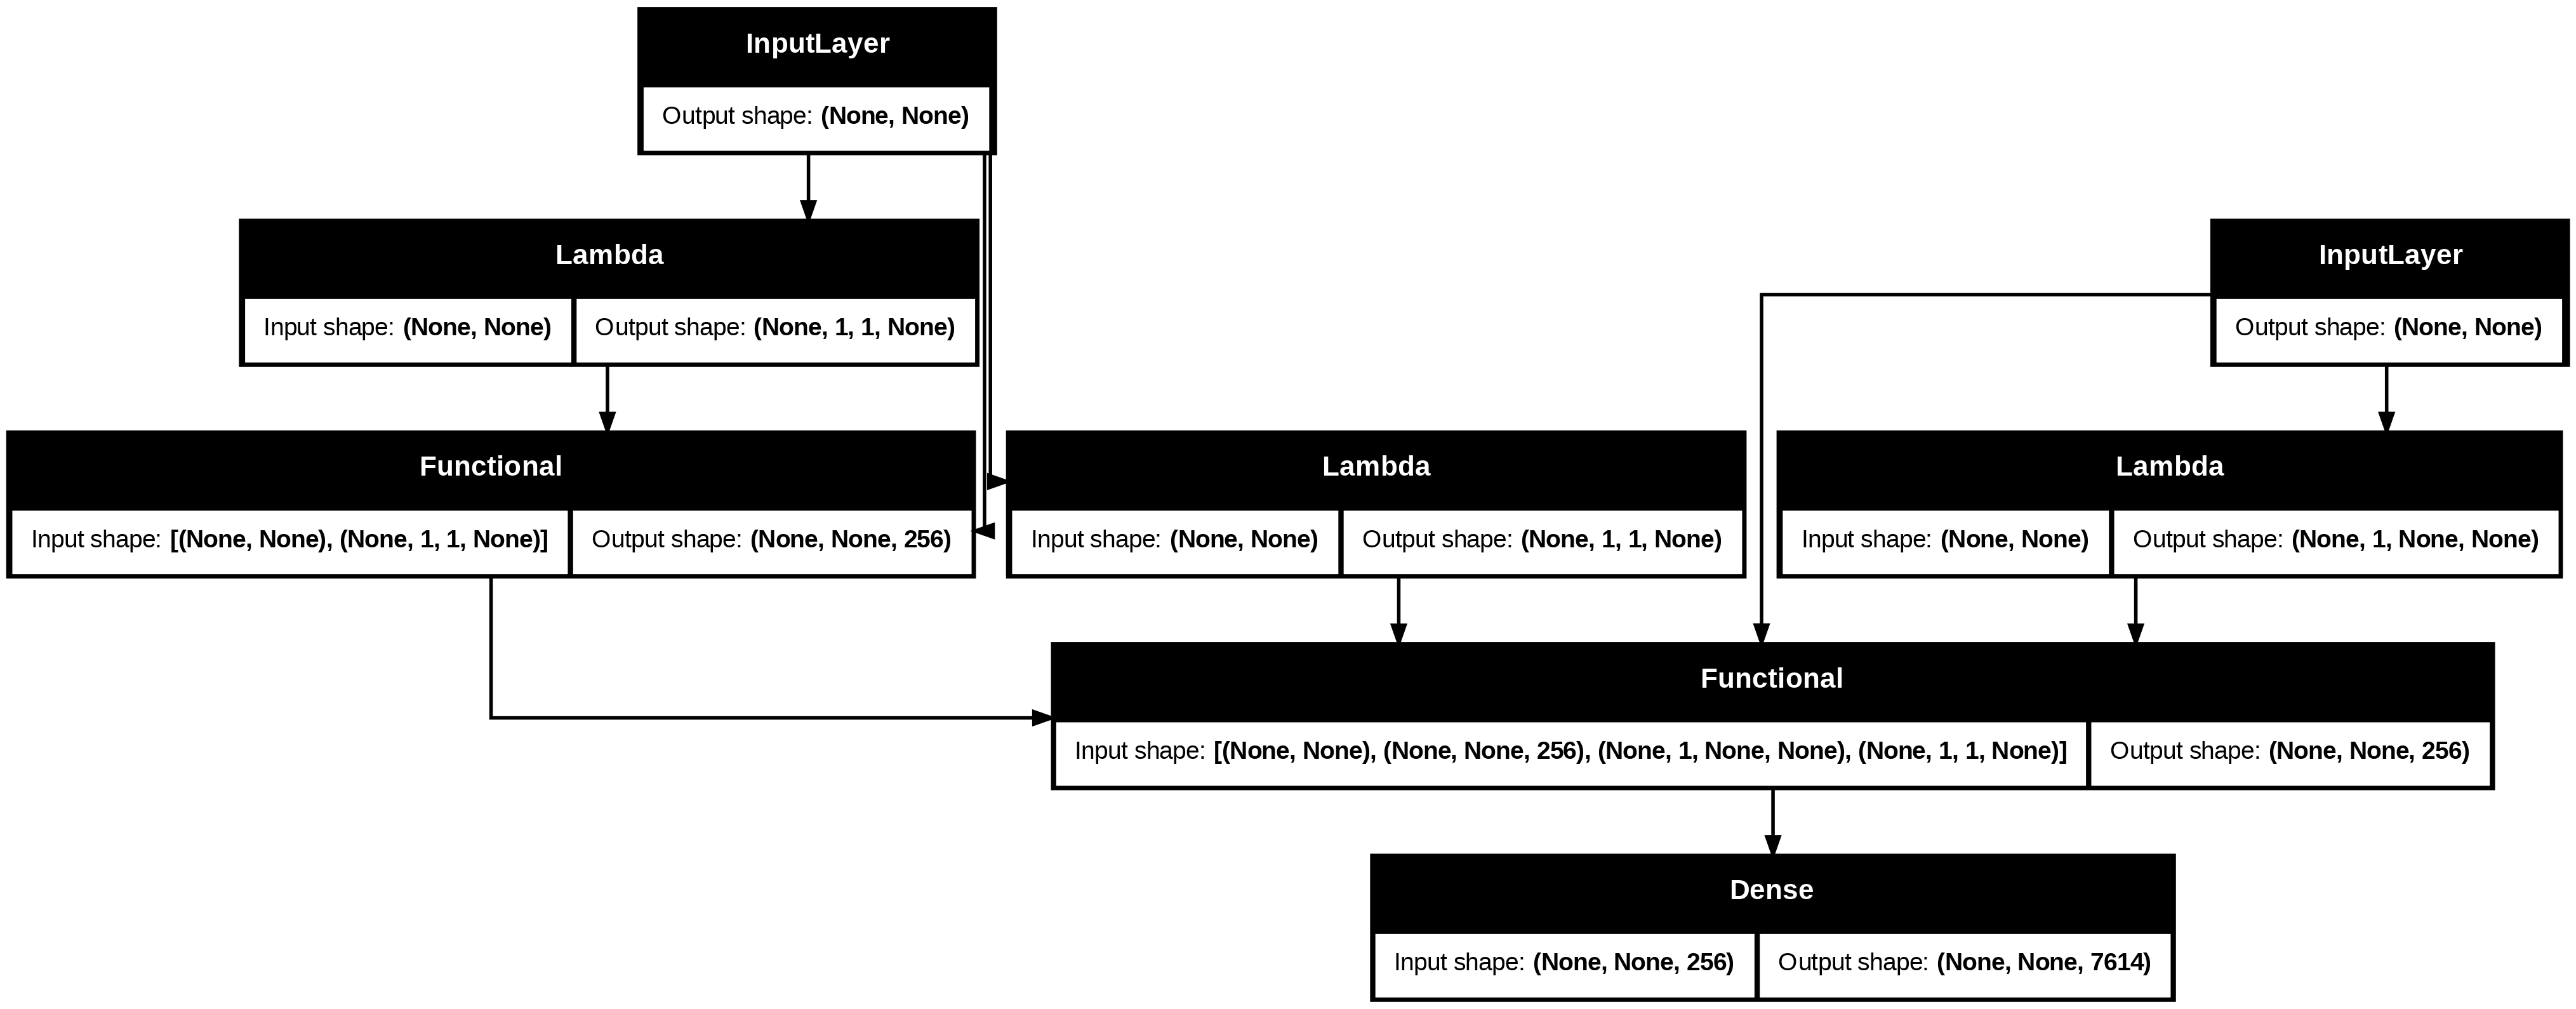

In [19]:
tf.keras.backend.clear_session()

#Hyper-parameters
D_MODEL    = 256
NUM_LAYERS = 2
NUM_HEADS  = 8
DFF        = 512
DROPOUT    = 0.1

model = transformer(vocab_size = VOCAB_SIZE,
                    num_layers = NUM_LAYERS,
                    dff        = DFF,
                    d_model    = D_MODEL,
                    num_heads  = NUM_HEADS,
                    dropout    = DROPOUT)
            # (1. 10025, 258)
model.summary()
tf.keras.utils.plot_model(model, to_file='transformer.png', show_shapes=True)

In [20]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.sqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

def loss_function(y_true, y_pred):
    #y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    y_pred = y_pred[:, :-1, :]  # 마지막 스텝 제거
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)


In [21]:
learning_rate= CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)

def accuracy(y_true, y_pred):
    # 레이블 크기 : (batch_size, MAX_LENGTH - 1)
    y_pred = y_pred[:, :-1, :]  # 마지막 스텝 제거
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


In [22]:
EPOCHS = 50
model.fit(dataset, verbose=1, epochs=EPOCHS)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 316s 4s/step - accuracy: 0.0052 - loss: 1.2160
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 313s 4s/step - accuracy: 0.0257 - loss: 1.0940
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 307s 4s/step - accuracy: 0.0256 - loss: 0.9812
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 313s 4s/step - accuracy: 0.0256 - loss: 0.8721
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 305s 4s/step - accuracy: 0.0296 - loss: 0.7898
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 331s 4s/step - accuracy: 0.0351 - loss: 0.7311
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 316s 4s/step - accuracy: 0.0414 - loss: 0.6771
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 331s 4s/step - accuracy: 0.0468 - loss: 0.6293
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 303s 4s/step - accuracy: 0.0517 - loss: 0.5727
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 334s 4s/step - accuracy: 0.0549 - loss: 0.5403
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 311s 4s/step - accuracy: 0.0584 - loss: 0.4869
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 334s 4s/step - accuracy:

In [27]:
def evaluate(sentence):

    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    output = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 예측 시작
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        # 현재 (마지막) 시점의 예측 단어를 받아온다.
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
        if tf.equal(predicted_id, END_TOKEN[0] ):
            break

        # 마지막 시점의 예측 단어를 출력에 연결한다.
        # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)


In [28]:
def predict(sentence):

    prediction = evaluate(sentence)
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence

def preprocess_sentence(sentence):

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()

    return sentence


In [29]:
output = predict('배고파')

Input: 배고파
Output: 로맨틱하네요 .


In [36]:
output = predict('아빠가 오래')

Input: 아빠가 오래
Output: 로맨틱하네요 .
